In [301]:
using StatsPlots, Plots, Measures
using Distributions, ARFIMA
using Statistics, StatsBase
using CSV, DataFrames
using Dates
using LsqFit
using SingularSpectrumAnalysis
using LaTeXStrings

In [2]:
γ(X,h)=begin
    n=length(X)
    x=mean(X)
    sum(@. (X[h+1:end]-x)*(X[1:n-h]-x) )/n
end

γ (generic function with 1 method)

# Działanie

## Wczytanie danych

In [61]:
File=CSV.read("testset.csv", DataFrame);
file=File[:,[:tempm]];
N=length(file[:,:tempm])

100990

In [62]:
file[:,:Date]=[Date(File[i,:datetime_utc][1:8], "yyyymmdd") for i in 1:N];
file[:,:h]=[parse(Int,File[i,:datetime_utc][10:11]) for i in 1:N];

In [63]:
file=file[file[:,:tempm].!==missing,:];

In [64]:
file[end,:Date]

2017-04-24

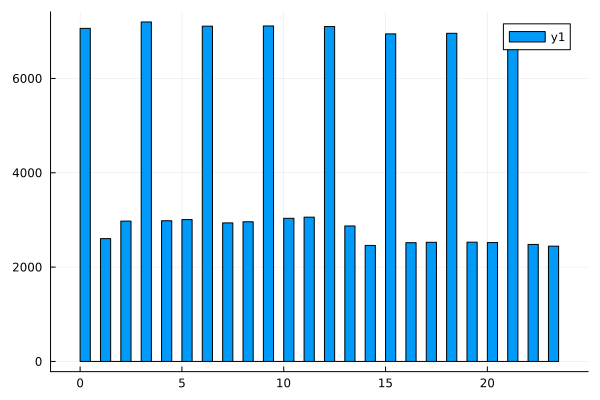

In [228]:
histogram(file[:,:h])

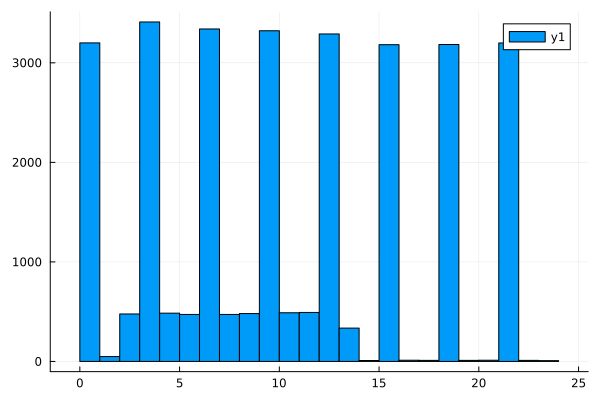

In [229]:
histogram(file[file[:,:Date].>=Date("2008-01-01"),:h])

In [65]:
file[1,:Date]

1996-11-01

## przekształcenie

In [66]:
size(file)

(100317, 3)

In [67]:
temp=file[:,:tempm];

In [68]:
qₘᵢₙ,qₘₐₓ=quantile(temp,0.25)-1.5*iqr(temp),quantile(temp,0.75)+1.5*iqr(temp)

(-0.5, 51.5)

In [69]:
file=file[(file[:,:tempm].>qₘᵢₙ) .& (file[:,:tempm].<qₘₐₓ), :];

In [70]:
size(file) #4 odstające

(100313, 3)

In [71]:
#X=combine(groupby(file,:Date),:tempm=>mean);
#X=X[(X[:,:Date].>=Date("2008-02-03")).&(X[:,:Date].<Date("2017-02-03")),:];

X=combine(groupby(file,:Date),:tempm=>mean);
X=X[(X[:,:Date].>=Date("2008-01-01")).&(X[:,:Date].<Date("2016-01-01")),:];
X=X[:,:tempm_mean];
fit_trend=curve_fit(model_trend,1:length(X),X,[1.,0.])
fit_trend.param
fit_trend.param[2]*365

In [74]:
minimum(file[:,:tempm])

1

In [76]:
X=combine(groupby(file,:Date),:tempm=>mean);
X=X[(X[:,:Date].>=Date("2008-01-01")).&(X[:,:Date].<Date("2016-01-01")),:];

In [77]:
sum(X[:,:tempm_mean])

73014.81867231411

In [78]:
rename!(X, :Date => :time, :tempm_mean => :temp);

In [79]:
sum(X[2:end,:time]-X[1:end-1,:time].!=Day(1))

0

In [80]:
CSV.write("Data.csv",X)

"Data.csv"

In [81]:
X=X[:,:temp];

In [82]:
N=length(X)

2922

In [83]:
argmax(X)

1630

In [85]:
minimum(X)

6.0

## Trend i sezonowość

### SingularSpectrumAnalysis

In [68]:
yt, ys = analyze(X, 20, robust=true)

([14.253977583712105, 14.414334041599915, 14.59171425700245, 14.787542426831372, 14.947902940089017, 15.07433376330201, 15.232667656841954, 15.40745937141891, 15.596181893048286, 15.793504160437777  …  14.906721785188358, 14.94947565947772, 14.985165130347886, 15.015658909952133, 15.067845215160263, 15.153075191865659, 15.268583348849505, 15.36403086741357, 15.450986450505189, 15.558752344102228], [-1.303545888092498; -1.6450999770098735; … ; 0.36692524485791733; 0.3009525630153872;;])

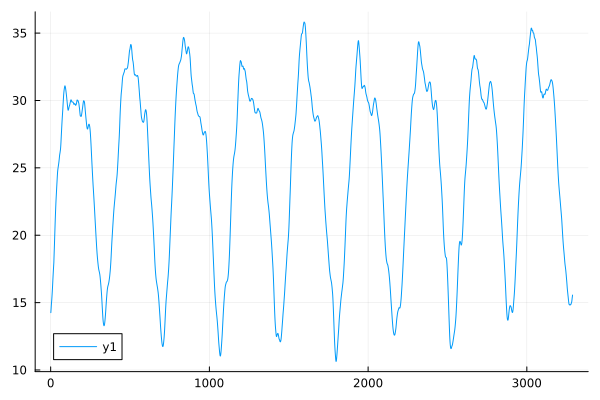

In [69]:
plot(yt)

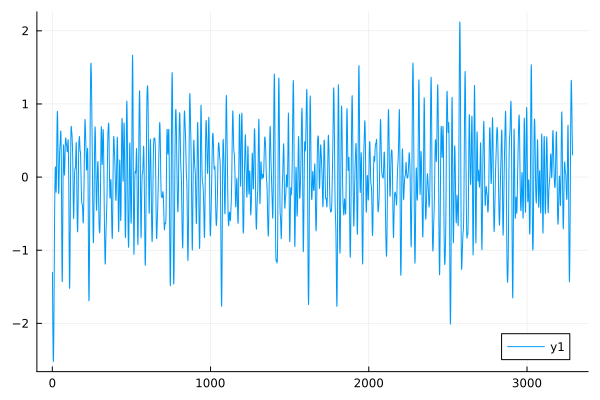

In [70]:
plot(ys)

In [22]:
Y=X.-ys.-yt;

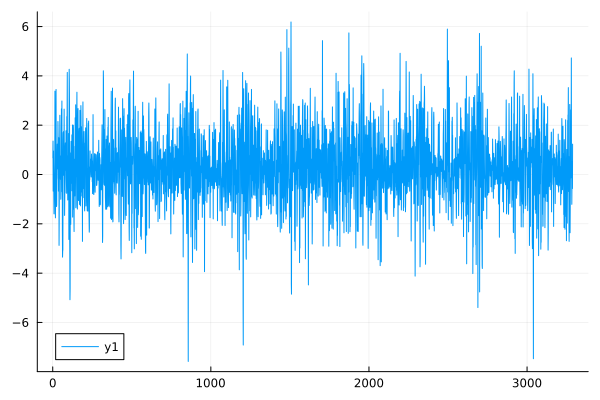

In [23]:
plot(Y)

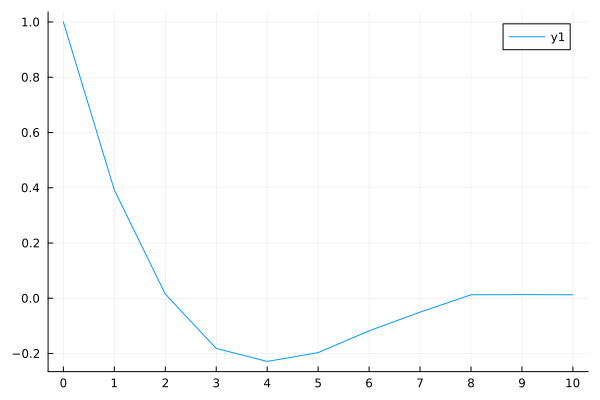

In [41]:
γ₀=γ(Y,0)
plot(0:1:10,h->γ(Y,h)/γ₀)
plot!(yticks=[i for i in -0.2:0.2:1])
plot!(xticks=[i for i in 0:10])

### Pół na pół

In [179]:
@. model_trend(x,p)=p[1]+p[2]*x

model_trend (generic function with 1 method)

In [180]:
fit_trend=curve_fit(model_trend,1:N,X,[1.,0.])

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}}([24.852176993111712, 9.467109909017854e-5], [14.727271664210804, 15.477366335309892, 14.227461006408983, 13.727555677508072, 10.281221777178592, 10.727745019706251, 9.602839690805343, 5.977934361904435, 6.603029033003523, 8.228123704102615  …  13.127953904761402, 12.628048575860493, 13.878143246959581, 13.628237918058673, 12.378332589157761, 9.753427260256853, 8.003521931355944, 8.753616602455033, 9.628711273554124, 10.128805944653212], [0.9999999999967198 1.0000000000235538; 0.9999999999967198 2.0000000000471077; … ; 0.9999999999967198 2921.0000000001573; 0.9999999999967198 2921.9999999998877], true, Float64[])

In [181]:
fits_trend.param

2-element Vector{Float64}:
 25.161203347180614
  5.6842075321836884e-5

In [182]:
ans[2]*365

0.02074735749247046

In [183]:
model_trend(N,fit_trend.param)-model_trend(1,fit_trend.param)

0.2765342804424087

In [184]:
Y=X .- model_trend.(1:N,Ref(fits_trend.param));

In [185]:
yt, ys = analyze(Y, 20, robust=true)

([-9.457963412328198, -9.524945756512805, -9.58730369282817, -9.660367024809704, -9.73853135273846, -9.821794766283757, -9.911375676797254, -10.014150033814643, -10.158228724265856, -10.323142824767269  …  -11.234118887200982, -11.339581598140066, -11.436228177469017, -11.519119123248846, -11.576191549107635, -11.62445309765858, -11.623036704783969, -11.576436416307054, -11.521536973593204, -11.382740802422052], [-0.9509255556996901 -0.4743124012981045; -0.8415502103584385 -0.6433792789124607; … ; 1.6161366159818238 0.2650304531133346; 1.5801603983858736 0.1097042662393834])

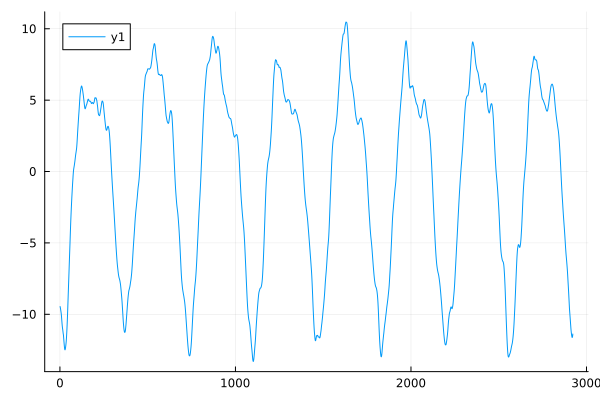

In [186]:
plot(yt)

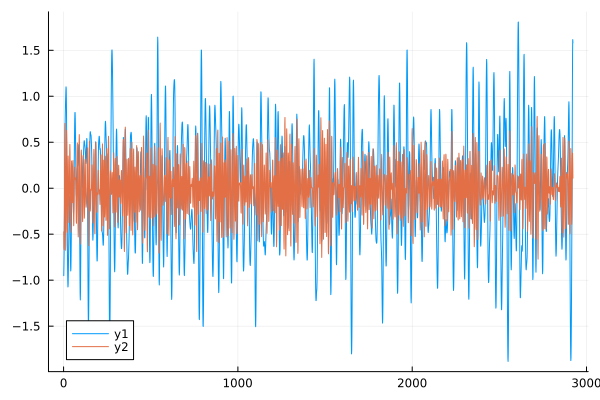

In [187]:
plot(ys)

In [77]:
W=Y.-yt;

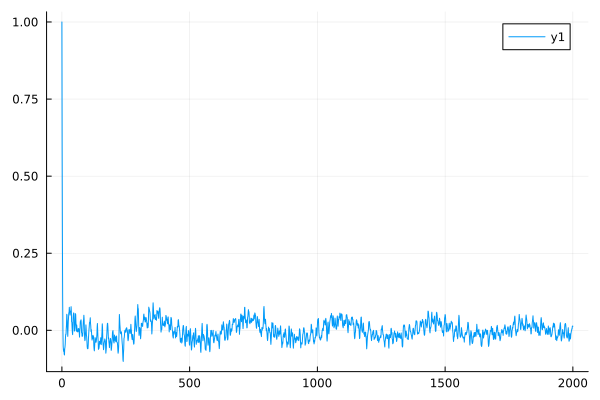

In [79]:
γ₀=γ(W,0)
plot(0:2000,h->γ(W,h)/γ₀)

### Własna przy złożeniu 30+

#### Trend

In [188]:
@. model_trend(x,p)=p[1]+p[2]*x

model_trend (generic function with 1 method)

In [189]:
fit_trend=curve_fit(model_trend,1:N,X,[1.,0.])

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}}([24.852176993111712, 9.467109909017854e-5], [14.727271664210804, 15.477366335309892, 14.227461006408983, 13.727555677508072, 10.281221777178592, 10.727745019706251, 9.602839690805343, 5.977934361904435, 6.603029033003523, 8.228123704102615  …  13.127953904761402, 12.628048575860493, 13.878143246959581, 13.628237918058673, 12.378332589157761, 9.753427260256853, 8.003521931355944, 8.753616602455033, 9.628711273554124, 10.128805944653212], [0.9999999999967198 1.0000000000235538; 0.9999999999967198 2.0000000000471077; … ; 0.9999999999967198 2921.0000000001573; 0.9999999999967198 2921.9999999998877], true, Float64[])

In [190]:
fit_trend.param

2-element Vector{Float64}:
 24.852176993111712
  9.467109909017854e-5

In [191]:
ans[2]*365

0.03455495116791517

In [192]:
model_trend(N,fit_trend.param)-model_trend(1,fit_trend.param)

0.2765342804424087

In [193]:
Y=X .- model_trend.(1:N,Ref(fits_trend.param));

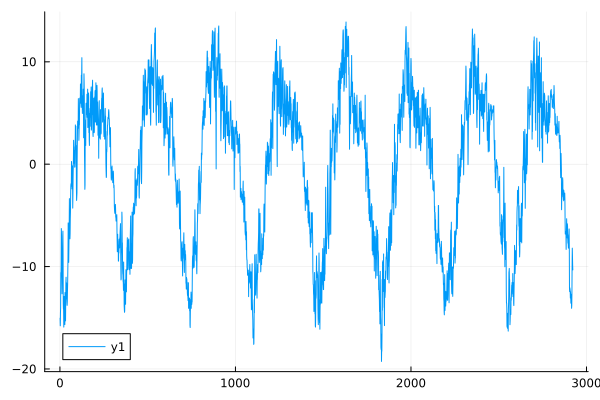

In [194]:
plot(Y)

#### Sezonowość

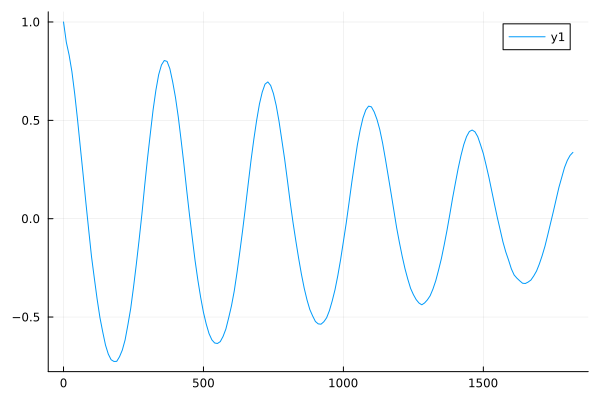

In [195]:
γ₀=γ(Y,0)
plot(0:10:365*5,h->γ(Y,h)/γ₀)

In [211]:
W=X[1:end-365]-X[366:end];

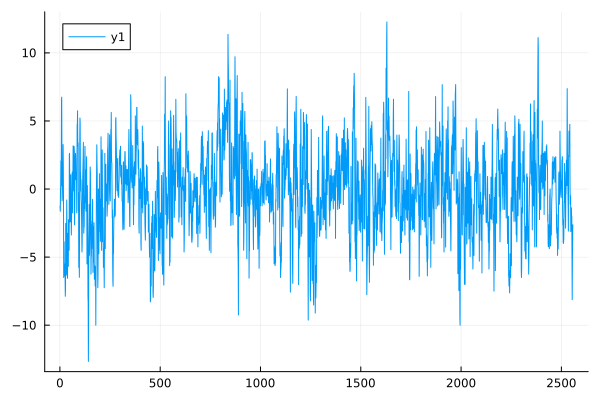

In [212]:
plot(W)

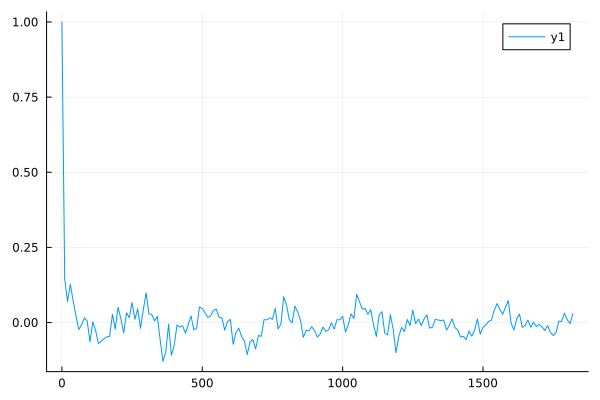

In [213]:
γ₀=γ(W,0)
plot(0:10:365*5,h->γ(W,h)/γ₀)

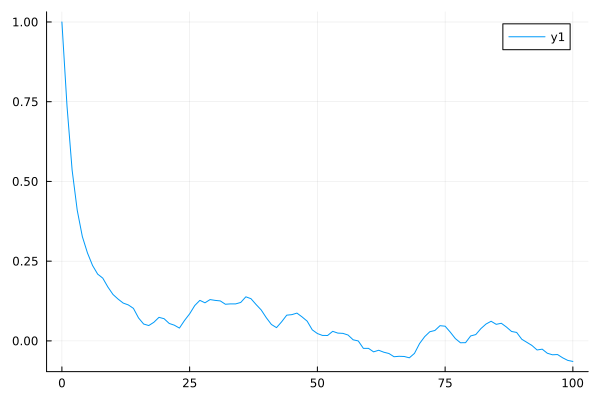

In [214]:
γ₀=γ(W,0)
plot(0:1:100,h->γ(W,h)/γ₀)

In [220]:
fit_trend=curve_fit(model_trend,1:length(W),W,[1.,0])

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}}([-0.24539209595668232, 0.00012716469246919015], [1.0047350687357868, 1.379862233428256, -0.15572488759356123, -0.5365501038534717, -2.3161848439229074, -0.4946291078018672, -2.119501943109398, -6.744374778416929, -6.994247613724459, -3.3691204490319904  …  2.703623540454814, 2.9537507051472836, 1.4538778698397525, 2.3290050345322215, 2.079132199224691, 5.07925936391716, 8.204386528609628, 5.329513693302099, 3.9546408579945678, 2.7047680226870368], [1.0000000000052196 1.0000000000052196; 1.0000000000052196 1.999999999992105; … ; 1.0000000000235538 2555.999999999994; 0.9999999999868854 2556.999999999981], true, Float64[])

In [221]:
fit_trend.param

2-element Vector{Float64}:
 -0.24539209595668232
  0.00012716469246919015

In [223]:
V=W.-model_trend.(1:length(W),Ref(fit_trend.param));

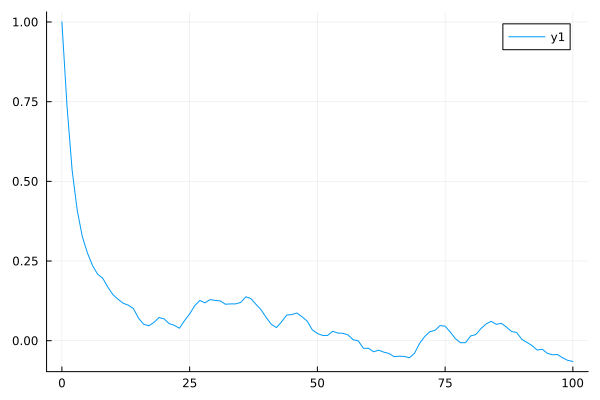

In [225]:
γ₀=γ(V,0)
plot(0:1:100,h->γ(V,h)/γ₀)

In [278]:
@. model_ses(x,p)=p[1]*sin(2π/p[2]*x+p[3])

model_ses (generic function with 1 method)

In [241]:
fit_ses=curve_fit(model_ses,1:length(V),V,[1.,200.,0.])

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}}([1.0, 202.66699070243396, 2.6775952100168876], [1.4243262899914895, 1.771114946109211, 0.20681329189799497, -0.203074885242219, -2.0120930820927145, -0.2202130588415857, -1.8750253424148984, -6.530072587220652, -6.810325793279201, -3.215755762665946  …  2.6942041350069403, 2.975331994310724, 1.5064391122990544, 2.4124957148013557, 2.193472076196419, 5.224338547981035, 8.380065587264589, 5.535623785162024, 4.190983895058133, 2.971116860715845], [0.0 0.00013885530270795369 -0.9077131743905722; 0.0 0.000281556370214139 -0.9202832796212798; … ; 0.0 -0.379921013081476 0.9716696806993119; 0.0 -0.37702141971543096 0.9638767016807919], true, Float64[])

In [242]:
fit_ses.param

3-element Vector{Float64}:
   1.0
 202.66699070243396
   2.6775952100168876

In [243]:
U=V.-model_ses.(1:length(V),Ref(fit_ses.param));

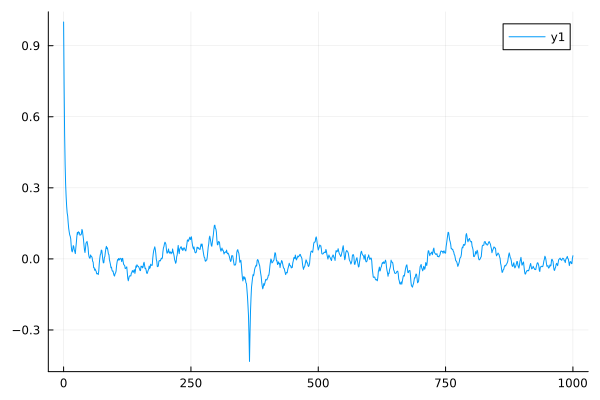

In [307]:
γ₀=γ(U,0)
plot(0:1:1000,h->γ(U,h)/γ₀)

In [305]:
fit_ses=curve_fit(model_ses,1:length(V),V,[12.,500.,3.])
U=V.-model_ses.(1:length(V),Ref(fit_ses.param));
γ₀=γ(U,0)
print(fit_ses.param)


[0.5935463134872346, 512.9783611831584, 3.6621625223354073]

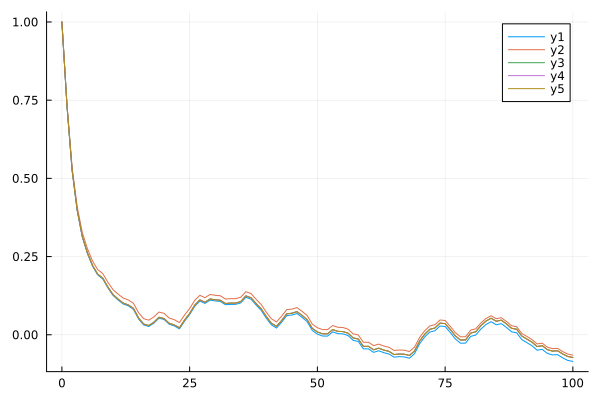

In [306]:
γ₀=γ(U,0)
plot!(0:1:100,h->γ(U,h)/γ₀)

### Różnicowanie

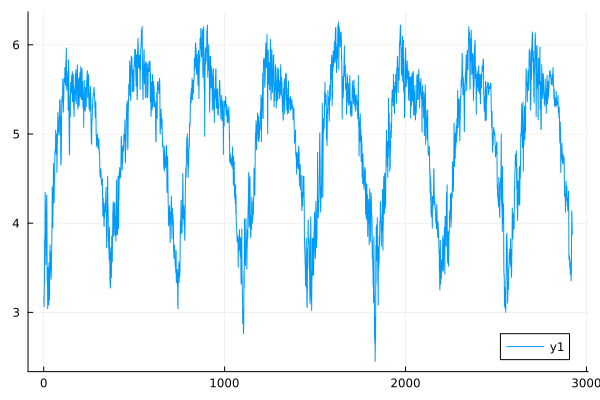

In [436]:
plot(sqrt.(X))


In [438]:
@. model_trend(x,p)=p[1]+p[2]*x

model_trend (generic function with 1 method)

In [439]:
fit_trend=curve_fit(model_trend,1:N,X,[1.,0.])
fits_trend.param

2-element Vector{Float64}:
 25.161203347180614
  5.6842075321836884e-5

In [440]:
ans[2]*365

0.02074735749247046

In [441]:
model_trend(N,fit_trend.param)-model_trend(1,fit_trend.param)

0.26308276196804314

In [442]:
Y=X .- model_trend.(1:N,Ref(fits_trend.param));

In [444]:
W=X[1:end-365]-X[366:end];

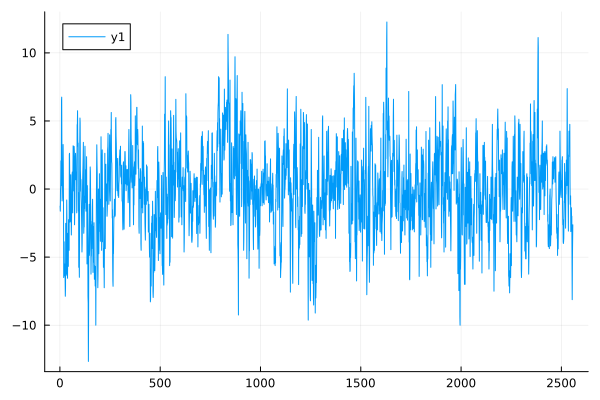

In [445]:
plot(W)

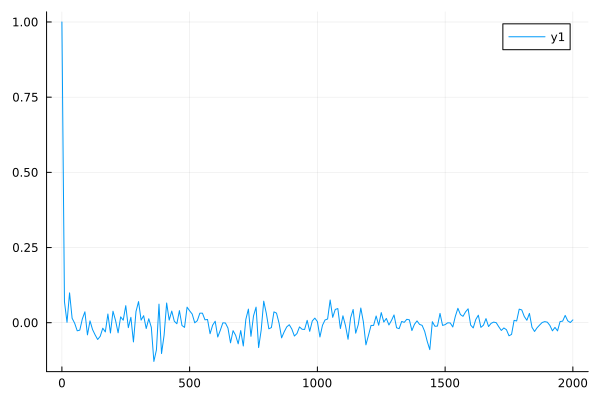

In [489]:
γ₀=γ(W,0)
plot(0:10:2000,h->γ(W,h)/γ₀)

In [450]:
fit_trend=curve_fit(model_trend,1:N,log.(X),[1.,0.])
fits_trend.param

2-element Vector{Float64}:
 25.161203347180614
  5.6842075321836884e-5

In [451]:
ans[2]*365

0.02074735749247046

In [486]:
Y=log.(X);

In [487]:
W=Y[1:end-365]-Y[366:end];

In [488]:
γ₀=γ(W,0)
sum(abs(γ(W,h)) for h in 20:2000)/γ₀

51.17686261621028

In [484]:
γ₀=γ(W,0)
sum(abs(γ(W,h)) for h in 20:2000)/γ₀

55.31119443436681

In [481]:
γ₀=γ(W,0)
sum(abs(γ(W,h)) for h in 20:2000)/γ₀

60.17246845817378

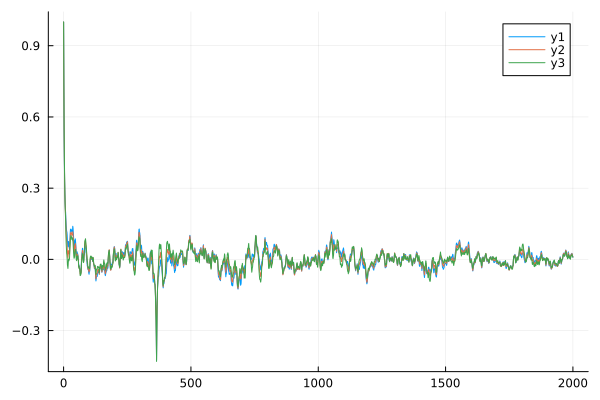

In [467]:
γ₀=γ(W,0)
plot!(0:2000,h->γ(W,h)/γ₀)

### Stabilizacja wariancji + różnicowanie sezonowe

In [86]:
λ=1.45915768222621

1.45915768222621

In [87]:
temp=X.^(λ);
tmp=(X).^(0.01);
temp2=log.(X);

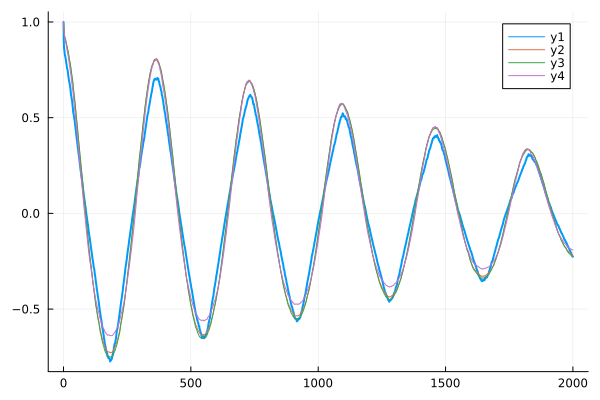

In [119]:
γ₀=γ(X,0)
plot!(0:2000,h->γ(X,h)/γ₀)
γ₀=γ(temp,0)
plot!(0:2000,h->γ(temp,h)/γ₀)
γ₀=γ(tmp,0)
plot!(0:2000,h->γ(tmp,h)/γ₀)

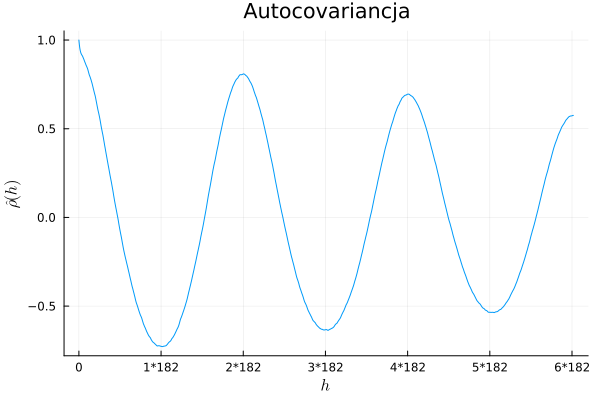

In [273]:
γ₀=γ(X,0)
plot(0:365*3,h->γ(X,h)/γ₀)
plot!(leg=false,dpi=500,title="Autocovariancja",ylabel=L"$\hat{\rho}(h)$", xlabel=L"$h$")
plot!(xticks=([i*182 for i in 0:6],[i!=0 ? "$i"*"*182" : "0" for i in 0:6]))
plt1=plot!()

In [247]:
savefig(plt1,"tex/Budnik/img/auto_dry.png")

"C:\\Git\\Kaszcz\\Raport 2\\tex\\Budnik\\img\\auto_dry.png"

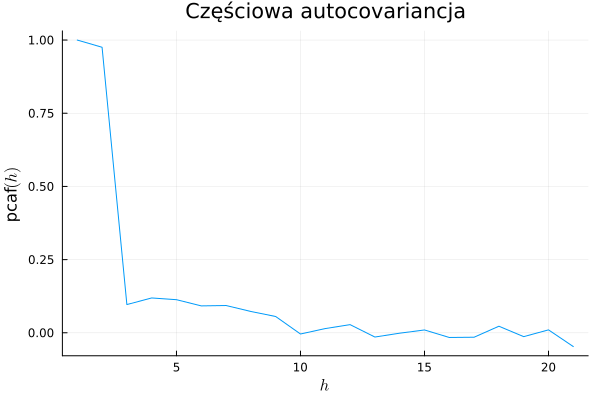

In [275]:
plot(pacf(X,0:20),leg=false,dpi=500,title="Częściowa autocovariancja",ylabel=L"pcaf$(h)$", xlabel=L"$h$")
plt2=plot!()

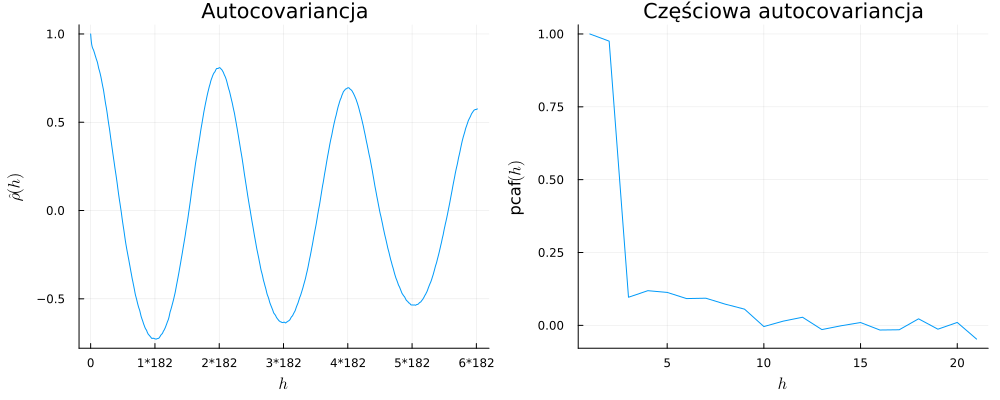

In [310]:
plot!(plt1,plt2, size=(1000,400), bottom_margin=5mm, left_margin=5mm)

In [311]:
savefig(plot!(),"tex/Budnik/img/auto_dry.png")

"C:\\Git\\Kaszcz\\Raport 2\\tex\\Budnik\\img\\auto_dry.png"

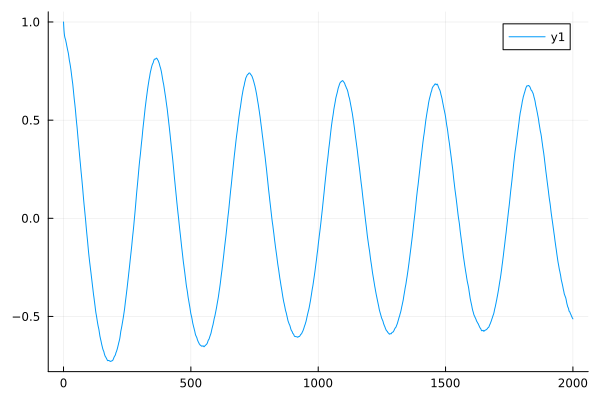

In [171]:
γ₀=γ(X,0)
plot(0:2000,h->γ(X,h)*(1+h^3/6000000000)/γ₀)

In [89]:
W=temp[1:end-365]-temp[366:end];
W2=temp2[1:end-365]-temp2[366:end];

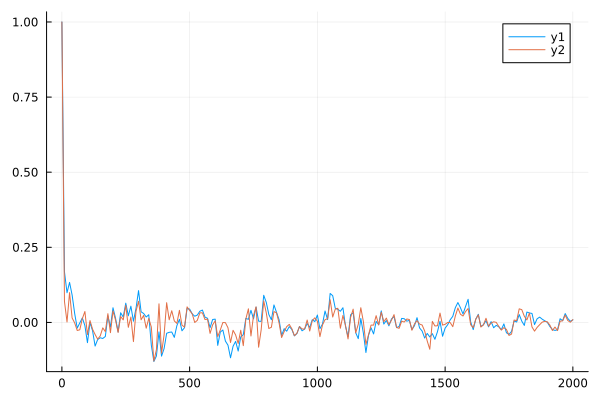

In [90]:
γ₀=γ(W,0)
plot(0:10:2000,h->γ(W,h)/γ₀)
γ₀=γ(W2,0)
plot!(0:10:2000,h->γ(W2,h)/γ₀)

In [91]:
maximum(abs(γ(W,h))/γ₀ for h in 20:10:2000)

2515.2602093022306

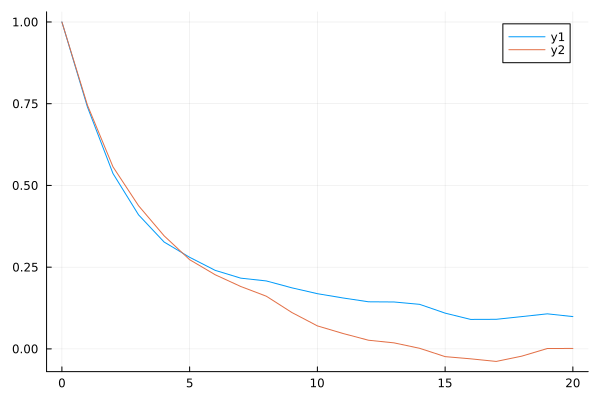

In [92]:
γ₀=γ(W,0)
plot(0:20,h->γ(W,h)/γ₀)
γ₀=γ(W2,0)
plot!(0:20,h->γ(W2,h)/γ₀)

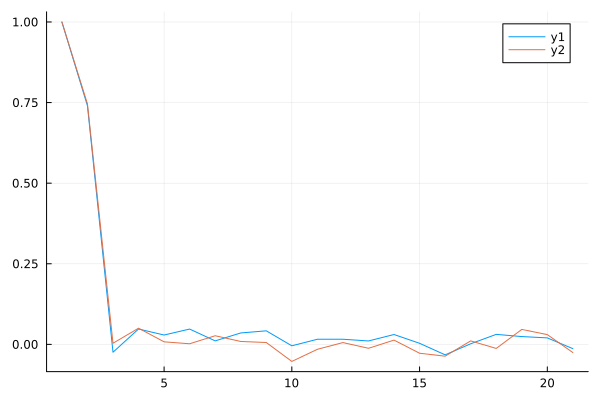

In [93]:
plot(pacf(W,0:20))
plot!(pacf(W2,0:20))

In [225]:
W=X[1:end-365]-X[366:end];

# Dobranie modelu

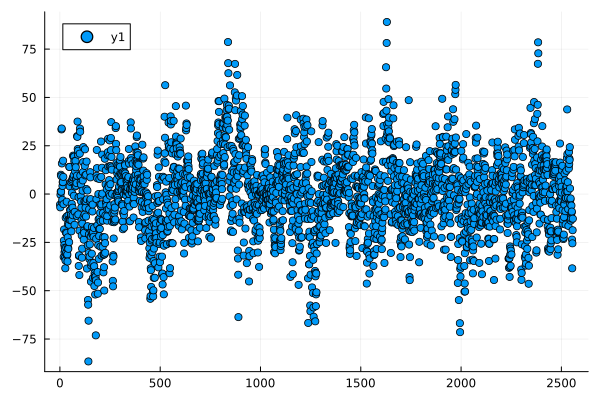

In [73]:
scatter(W)

In [74]:
CSV.write("w.csv",  Tables.table(W), writeheader=["X"])

"w.csv"

Gotowy kod w pythonie :'<

In [75]:
pq=CSV.read("pq.csv", DataFrame);

In [76]:
pq

,Column1,p,q,AIC,BIC,HQIC
,Int64,Int64,Int64,Float64,Float64,Float64
1,0,0,0,22612.2,22623.9,22616.4
2,1,0,1,21261.0,21278.5,21267.3
3,2,0,2,20880.0,20903.4,20888.5
4,3,0,3,20718.9,20748.2,20729.5
5,4,0,4,20672.0,20707.1,20684.7
6,5,1,0,20586.9,20604.4,20593.2
7,6,1,1,20587.1,20610.5,20595.6
8,7,1,2,20582.8,20612.0,20593.4
9,8,1,3,20580.9,20616.0,20593.6


In [77]:
#X=combine(groupby(file,:Date),:tempm=>mean);


In [78]:
pq

,Column1,p,q,AIC,BIC,HQIC
,Int64,Int64,Int64,Float64,Float64,Float64
1,0,0,0,22612.2,22623.9,22616.4
2,1,0,1,21261.0,21278.5,21267.3
3,2,0,2,20880.0,20903.4,20888.5
4,3,0,3,20718.9,20748.2,20729.5
5,4,0,4,20672.0,20707.1,20684.7
6,5,1,0,20586.9,20604.4,20593.2
7,6,1,1,20587.1,20610.5,20595.6
8,7,1,2,20582.8,20612.0,20593.4
9,8,1,3,20580.9,20616.0,20593.6


In [79]:
PQ=zeros(5,5,3);

In [80]:
for i in 1:5
    for j in 1:5
        PQ[i,j,:]=Vector(pq[5*(i-1)+j,[:AIC,:BIC,:HQIC]])
    end
end

In [81]:
argmin(PQ[:,:,1]),argmin(PQ[:,:,2]),argmin(PQ[:,:,3])

(CartesianIndex(3, 3), CartesianIndex(3, 3), CartesianIndex(3, 3))

Za każdym razem $p=2$, $q=2$

In [82]:
using ARCHModels

In [87]:
W[end-10:end]

11-element Vector{Float64}:
 -13.736792901657381
 -11.359937256255694
 -12.639465289278075
  -5.92105449333706
  -9.606641880033013
  -9.043112423794529
 -23.547123720114104
 -38.422110594058914
 -25.48364807590645
 -18.70371865917891
 -12.72969153690142

In [88]:
fit_arma(df, p, q) = fit(ARCH{0}, df, meanspec=ARMA{p,q});
fit_arma(W, 2, 2)


TGARCH{0, 0, 0} model with Gaussian errors, T=2557.

Mean equation parameters:
──────────────────────────────────────────────
      Estimate  Std.Error    z value  Pr(>|z|)
──────────────────────────────────────────────
c   -0.103864   0.185779   -0.559072    0.5761
φ₁   1.0        0.321778    3.10773     0.0019
φ₂  -0.15683    0.241785   -0.648636    0.5166
θ₁  -0.245145   0.32171    -0.762006    0.4461
θ₂  -0.0822948  0.0271713  -3.02874     0.0025
──────────────────────────────────────────────

Volatility parameters:
─────────────────────────────────────────
   Estimate  Std.Error  z value  Pr(>|z|)
─────────────────────────────────────────
ω   404.559    80.9366  4.99847    <1e-06
─────────────────────────────────────────


# Test

In [93]:
Coffj=[-0.103864, 1.0, -0.15683, -0.245145, -0.0822948]
Coffp=[-0.4207, 1.5957, -0.6069, -0.8447, -0.0847];

In [98]:
N=length(W)

2557

In [120]:
Xj = arfima(N, 1, nothing, SVector(Coffj[2:3]...),SVector(Coffj[4:5]...)) # ARFIMA(2,0,0)
Xp = arfima(N, 1, nothing, SVector(Coffp[2:3]...),SVector(Coffp[4:5]...)); # ARFIMA(2,0,0)


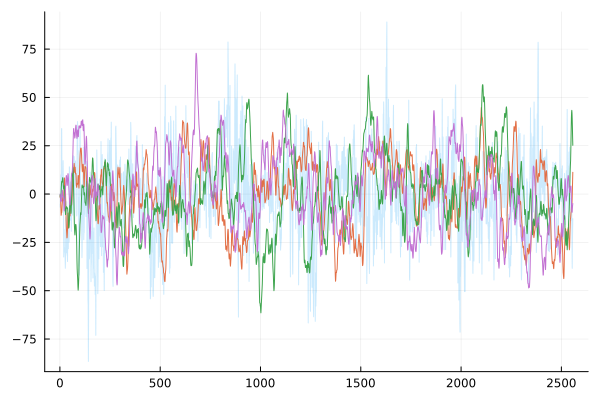

In [167]:
Xj = arfima(N, 1, nothing, SVector(Coffj[2:3]...),SVector(Coffj[4:5]...)) # ARFIMA(2,0,0)
Xp = [arfima(N, 1, nothing, SVector(Coffp[2:3]...),SVector(Coffp[4:5]...)) for i in 1:3]; # ARFIMA(2,0,0)

plot(W, label="W", alpha=0.2)
#plot!(Xj, label="J")
plot!(Xp, label="p")
plot!(leg=false)

# Reszta

## Trend

In [827]:
@. model_trend(x,p)=p[1]+p[2]*x

model_trend (generic function with 1 method)

In [938]:
fits_trend=curve_fit(model_trend,1:N,X,[1.,0.])

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}}([25.161203347180614, 5.6842075321836884e-5], [11.536260189255934, 11.036317031331258, 13.161373873406578, 12.01857357262476, 11.590058986128652, 12.911544399632543, 13.411601241707867, 13.786658083783188, 13.411714925858512, 12.411771767933832  …  6.999762425204395, 4.3476453542362385, 9.169130767740132, 8.847759038386883, 10.48417951682584, 9.681206055870861, 8.903485120168405, 9.222986406688168, 10.098043248763492, 8.257190999929723], [1.0000000000008662 1.0000000000235538; 1.0000000000008662 2.0000000000471077; … ; 1.0000000000008662 3286.9999999999777; 1.0000000000008662 3288.0000000000014], true, Float64[])

In [939]:
fits_trend.param

2-element Vector{Float64}:
 25.161203347180614
  5.6842075321836884e-5

In [940]:
ans[2]*365

0.02074735749247046

In [941]:
model_trend(N,fits.param)-model_trend(1,fits.param)

0.18683990158287855

In [942]:
Y=X .- model_trend.(1:N,Ref(fits_trend.param));

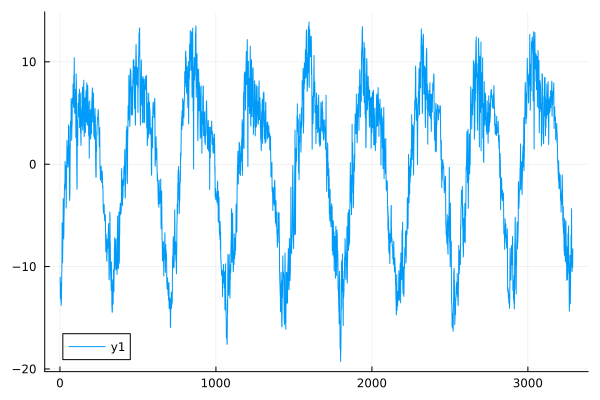

In [943]:
plot(Y)

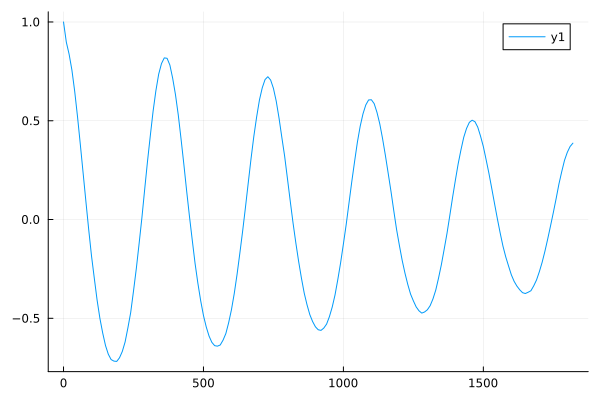

In [944]:
γ₀=γ(Y,0)
plot(0:10:365*5,h->γ(Y,h)/γ₀)

## Sezonowość

###### 1

In [1416]:
@. model_ses(x,p)=p[1]*sin(2π/p[2]*x+p[3])

model_ses (generic function with 1 method)

In [1417]:
fit_ses=curve_fit(model_ses,1:N,Y,[1.,365.,0.])

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}}([9.325083803494246, 365.0, -1.0716173679928707], [3.427114202096959, 3.007626762578113, 5.2155183972592205, 4.1579074175463795, 3.8169114371480672, 5.2282188081267815, 5.820374342869439, 6.289779321974311, 6.011405788052207, 5.110225125439384  …  -1.604047450937518, -4.192989522584623, 0.6942016646762941, 0.44104701347728437, 2.148175660275136, 1.4183805055274767, 0.7162863295692858, 1.1138404195291614, 2.0693529800103274, 0.31133552378232565], [-0.8696056955673375 0.0 4.60423058736915; -0.8609778140350218 0.0 4.743134038839068; … ; -0.8609778140192929 0.0 4.743134040618401; -0.8520948061758706 0.0 4.880631999215779], true, Float64[])

In [1418]:
fit_ses.param

3-element Vector{Float64}:
   9.325083803494246
 365.0
  -1.0716173679928707

In [1419]:
W=Y.-model_ses.(1:N,Ref(fit_ses.param));

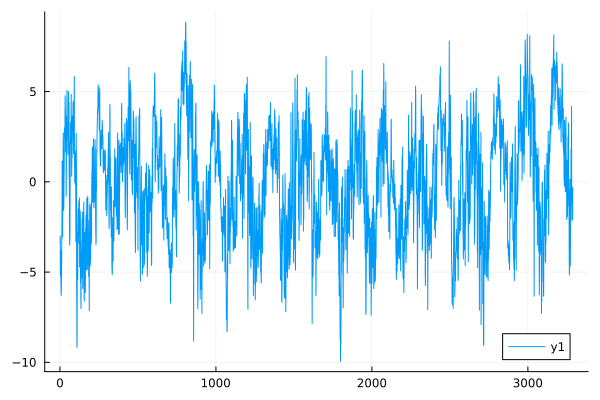

In [1420]:
plot(W)

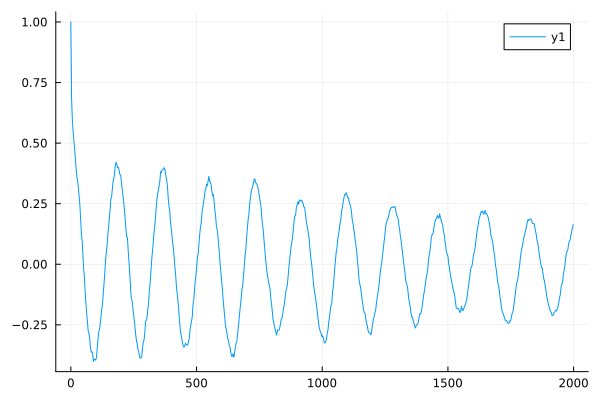

In [1421]:
γ₀=γ(W,0)
plot(0:3:2000,h->γ(W,h)/γ₀)

In [1119]:
γ₀=γ(W,0)
anim=@animate for i in 1:10
    plot(0:3:2000,h->γ(temp!(W,model_ses,fit_ses.param),h)/γ₀, title="$i")
end

Animation("C:\\Users\\Kacper\\AppData\\Local\\Temp\\jl_KZjwTB", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"])

###### 2

In [1128]:
temp=zeros(100,length(Y));

In [1146]:
temp[1,:]=Y
for i in 2:100
    fit_ses=curve_fit(model_ses,1:N,temp[i-1,:],[1.,365.,0.])
    temp[i,:]=temp[i-1,:].-model_ses.(1:N,Ref(fit_ses.param))
end

In [1147]:
anim=@animate for i in 36:38
    γ₀=γ(temp[i,:],0)
    plot(0:3:2000,h->γ(temp[i,:],h)/γ₀, title="$(i-1)")
end

Animation("C:\\Users\\Kacper\\AppData\\Local\\Temp\\jl_SyDKXi", ["000001.png", "000002.png", "000003.png"])

###### 3

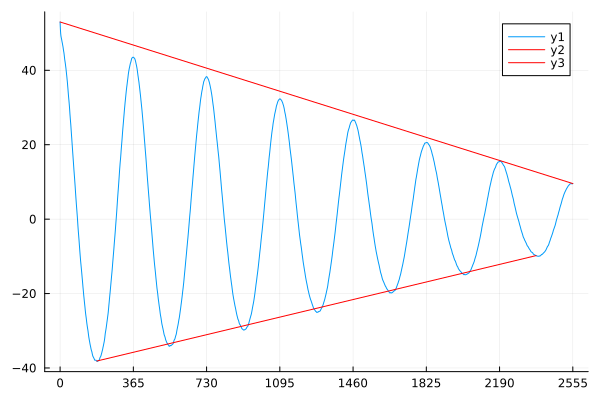

In [1700]:
plot(0:1:7*365,h->γ(Y,h))
plot!([0,7*365],[γ(Y,0),γ(Y,7*365)],c=:red)
plot!([183,7*365-183],[γ(Y,183),γ(Y,7*365-183)],c=:red)
plot!(xticks=[i*365 for i in 0:7])

In [1701]:
(γ(Y,7*365)-γ(Y,0))/(7*365),γ(Y,0)

(-0.016996999041300708, 52.98277224739827)

In [1707]:
(γ(Y,7*365-183)-γ(Y,183))/(6*365)

0.012935707672177756

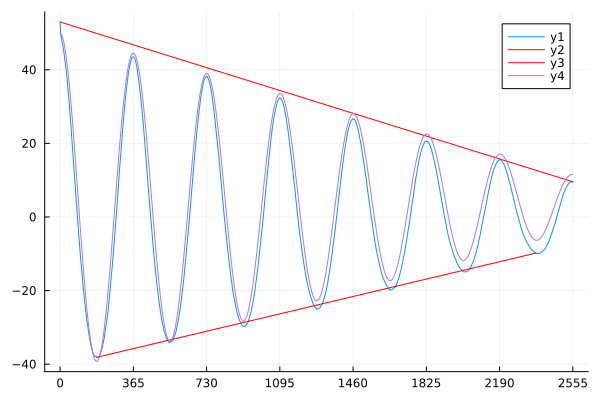

In [1727]:
plot(0:1:7*365,h->γ(Y,h))
plot!([0,7*365],[γ(Y,0),γ(Y,7*365)],c=:red)
plot!([183,7*365-183],[γ(Y,183),γ(Y,7*365-183)],c=:red)
plot!(xticks=[i*365 for i in 0:7])
plot!(h->model_ses(h,[-0.015,366.,π/2,46.,4]))

[-4.9361743166601856e-5, 366.3459730130054, 2.172577314620264, -9.266789928392592, -0.020844747566505735]

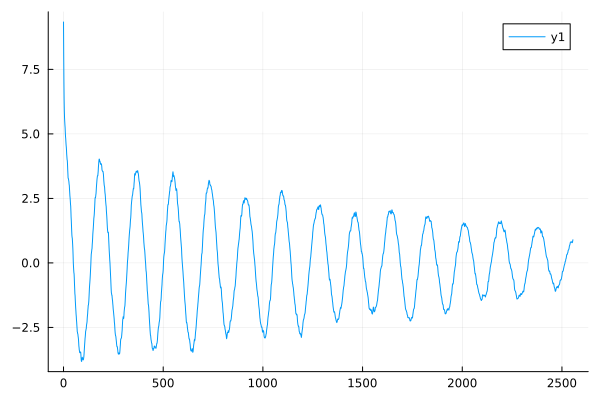

In [1728]:
@. model_ses(x,p)=(p[1]*x+p[4])*sin(2π/p[2]*x+p[3])+p[5]
fit_ses=curve_fit(model_ses,1:N,Y,[-0.017,365.,π/2,53.,3.])
print(fit_ses.param)
W=Y.-model_ses.(1:N,Ref(fit_ses.param));
plot(0:1:7*365,h->γ(W,h))

[1.0638938139464655, 366.30616896160313, 1.5852792628791066, 0.01320429937948623, 42.196739667259536]

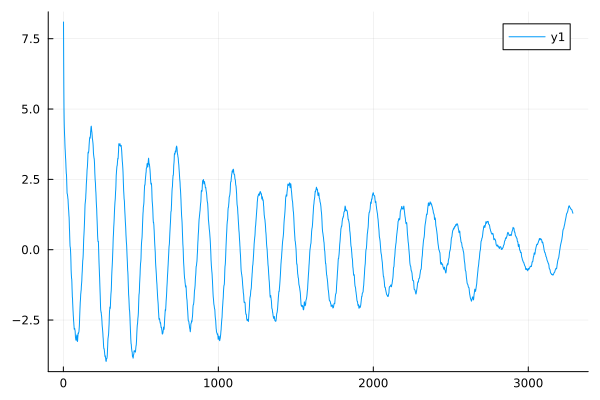

In [1698]:
@. model_ses(x,p)=p[1]*sin(2π/p[2]*x+p[3])*(p[5]-p[4]*x)
fit_ses=curve_fit(model_ses,1:N,γ.(Ref(Y),1:N),[1.,365.,2.,0.024,1.])
print(fit_ses.param)
W=Y.-model_ses.(1:N,Ref(fit_ses.param));
plot(γ.(Ref(Y),0:N-1).-model_ses.(0:N-1,Ref(fit_ses.param)))